# Compare
- BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
- WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
- Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
from warp import WARPNaive, KosWARP
from bpr import BPR 

In [18]:
dtype = np.float32

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

### learning rate decay

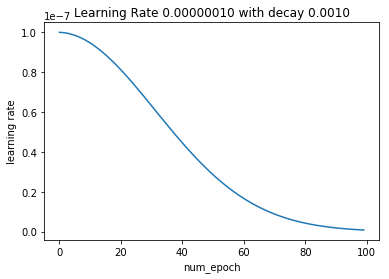

In [7]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

## helpers

In [27]:
def plot_auc(title, auc_scores, num_epochs):
    epoch_x = np.arange(num_epochs)
    test_line, = plt.plot(epoch_x, auc_scores, label="auc test")
    plt.legend([test_line], ["test auc"])
    plt.xlabel("num_epoch")
    plt.ylabel("auc_score")
    plt.title(title)
    plt.show()

# WARP class

In [8]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_warp_auc = []
tst_warp_prec5 = []

model = WARPNaive(lr=5e-5, item_reg=0.2, user_reg=0.2)
num_epochs = 15
for epoch in range(num_epochs):
    start = time.time()
    model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
    tst_warp_auc.append(tst_auc)
    tst_warp_prec5.append(tst_prec5)
    print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f" % (epoch, duration, tst_auc, tst_prec5))

/Users/timwee/anaconda3/lib/python3.5/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


initializing embeddings and biases
warp iteration 0 took 5.1573, auc: 0.7749, p@5: 0.0416
warp iteration 1 took 5.4672, auc: 0.7785, p@5: 0.0424
warp iteration 2 took 5.2647, auc: 0.7823, p@5: 0.0428
warp iteration 3 took 5.1342, auc: 0.7842, p@5: 0.0420
warp iteration 4 took 5.1967, auc: 0.7856, p@5: 0.0420
warp iteration 5 took 5.1965, auc: 0.7850, p@5: 0.0416
warp iteration 6 took 5.2340, auc: 0.7838, p@5: 0.0416
warp iteration 7 took 5.2702, auc: 0.7825, p@5: 0.0431
warp iteration 8 took 5.2392, auc: 0.7825, p@5: 0.0422
warp iteration 9 took 5.3322, auc: 0.7844, p@5: 0.0433
warp iteration 10 took 5.1593, auc: 0.7844, p@5: 0.0420
warp iteration 11 took 5.2611, auc: 0.7861, p@5: 0.0416
warp iteration 12 took 5.2706, auc: 0.7835, p@5: 0.0416
warp iteration 13 took 5.2406, auc: 0.7843, p@5: 0.0416
warp iteration 14 took 5.4227, auc: 0.7829, p@5: 0.0416


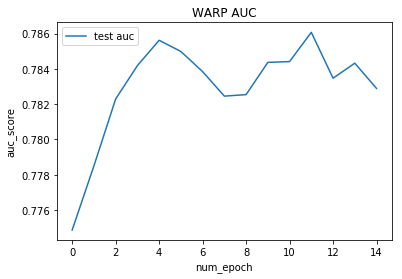

In [28]:
plot_auc("WARP AUC", tst_warp_auc, num_epochs)

## BPR Class

In [19]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []

bpr_model = BPR(lr=5e-5, item_reg=0.2, user_reg=0.2)
num_epochs = 15
for epoch in range(num_epochs):
    start = time.time()
    bpr_model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
    tst_bpr_auc.append(tst_auc)
    tst_bpr_prec5.append(tst_prec5)
    print("iteration %d took %.4f, auc: %.4f, p@5: %.4f" % (epoch, duration, tst_auc, tst_prec5))

initializing embeddings and biases
warp iteration 0 took 5.7914, auc: 0.7661, p@5: 0.0403
warp iteration 1 took 5.7583, auc: 0.7793, p@5: 0.0418
warp iteration 2 took 5.7936, auc: 0.7841, p@5: 0.0390
warp iteration 3 took 5.7041, auc: 0.7846, p@5: 0.0416
warp iteration 4 took 5.6846, auc: 0.7815, p@5: 0.0428
warp iteration 5 took 5.7074, auc: 0.7818, p@5: 0.0433
warp iteration 6 took 5.6412, auc: 0.7833, p@5: 0.0433
warp iteration 7 took 5.6223, auc: 0.7833, p@5: 0.0386
warp iteration 8 took 5.8275, auc: 0.7826, p@5: 0.0428
warp iteration 9 took 5.8159, auc: 0.7816, p@5: 0.0422
warp iteration 10 took 5.8198, auc: 0.7826, p@5: 0.0420
warp iteration 11 took 5.8693, auc: 0.7851, p@5: 0.0420
warp iteration 12 took 5.7239, auc: 0.7819, p@5: 0.0428
warp iteration 13 took 5.5725, auc: 0.7818, p@5: 0.0416
warp iteration 14 took 5.6730, auc: 0.7831, p@5: 0.0416


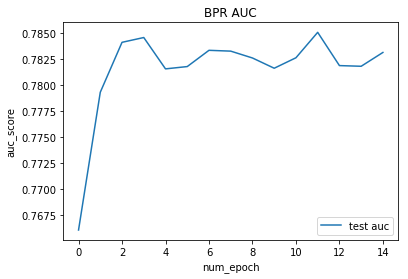

In [35]:
plot_auc("BPR AUC", tst_bpr_auc, len(tst_bpr_auc))

# KOS Warp

In [36]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []

kos_model = KosWARP(lr=5e-7, item_reg=0.2, user_reg=0.2)
num_epochs = 20
for epoch in range(num_epochs):
    start = time.time()
    kos_model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
    tst_koswarp_auc.append(tst_auc)
    tst_koswarp_prec5.append(tst_prec5)
    print("iteration %d took %.4f, auc: %.4f, p@5: %.4f" % (epoch, duration, tst_auc, tst_prec5))

initializing embeddings and biases
iteration 0 took 9.0133, auc: 0.6852, p@5: 0.0348
iteration 1 took 9.0977, auc: 0.7560, p@5: 0.0411
iteration 2 took 9.1042, auc: 0.7873, p@5: 0.0441
iteration 3 took 9.1842, auc: 0.8028, p@5: 0.0456
iteration 4 took 9.0550, auc: 0.8114, p@5: 0.0488
iteration 5 took 9.5415, auc: 0.8158, p@5: 0.0492
iteration 6 took 9.1294, auc: 0.8186, p@5: 0.0498
iteration 7 took 9.0209, auc: 0.8208, p@5: 0.0481
iteration 8 took 8.9953, auc: 0.8225, p@5: 0.0490
iteration 9 took 9.2112, auc: 0.8234, p@5: 0.0524
iteration 10 took 9.0483, auc: 0.8239, p@5: 0.0494
iteration 11 took 9.0251, auc: 0.8245, p@5: 0.0507
iteration 12 took 9.0496, auc: 0.8253, p@5: 0.0486
iteration 13 took 9.3104, auc: 0.8258, p@5: 0.0511
iteration 14 took 9.0083, auc: 0.8260, p@5: 0.0503
iteration 15 took 9.0741, auc: 0.8265, p@5: 0.0517
iteration 16 took 9.1133, auc: 0.8269, p@5: 0.0501
iteration 17 took 9.0577, auc: 0.8274, p@5: 0.0503
iteration 18 took 8.9231, auc: 0.8271, p@5: 0.0490
iterat

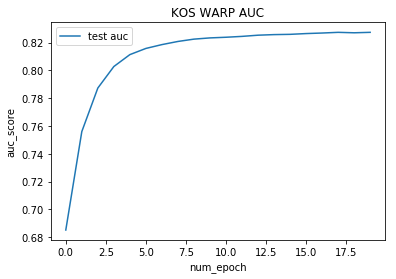

In [37]:
plot_auc("KOS WARP AUC", tst_koswarp_auc, len(tst_koswarp_auc))